# Myanmar Next Syllable Prediction using LSTM

This notebook implements a deep learning approach to **Next Syllable Prediction** for the Myanmar language. Due to the unique script characteristics of Myanmar, where standard word-level tokenization is difficult, this project utilizes a linguistically aware syllable-breaking strategy.

---

#### Pre-setup

In [1]:
import numpy as np
# Set random seeds for reproducibility across numpy and tensorflowimport numpy as np
np.random.seed(42)

from tensorflow import random
random.set_seed(42)

# Set up mixed precision for performance improvement on compatible GPUsfrom keras import mixed_precision
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# For plotting and setting plot stylesimport seaborn as sns
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [2]:
import tensorflow as tf
print("Devices: ", tf.config.list_physical_devices())
# You should see 'GPU' in the list (this is the Metal/MPS device)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Phase 1: Linguistic Analysis and Syllable Extraction
Unlike space-delimited languages like English, Myanmar text is written as a continuous stream of characters. Identifying word boundaries is complex; therefore, this project utilizes **Syllable Breaking** as the core tokenization logic.



* **Base Syllable Extraction (`syllable_base_pattern`):** Segments a full input sentence into individual, linguistically valid syllables by grouping consonants, medials, vowels, and tones.
* **Consonant and Rhyme Extraction (`syllable_break_pattern`):** Specifically isolates the **Onset (Consonant)** from the **Rhyme (Tail/Vowels/Medials)**. This allows the model to provide suggestions even while a user is mid-syllable.

In [3]:
import re

cons = "\u1000-\u1021"
cons_init = f"[{cons}\u1025\u1027\u1029\u103f]"
# consonants + independent_vowel (!caution! 103F is need extra requirement)
medial = "[\u103b-\u103e]{1,4}"
vowel = "[\u102b-\u1032]{1,2}\u103a?"
independent_vowel = "[\u1023-\u1027\u1029\u102a]"
asat = "\u103a"
virama = "\u1039"
cons_asat = f"[{cons}](?:{asat}{virama}|[{asat}{virama}])"
kinzi = f"[\u1004\u101b]{asat}{virama}"
tone = "[\u1036\u1037\u1038]{1,2}"
legaund = f"\u104e\u1004{asat}\u1038|\u104e\u1004{asat}"
symbol1 = f"[\u104c\u104d\u104f]|{legaund}|\u104e"
symbol2 = f"{cons}\u103b{asat}"
contra1 = "\u103b\u102c"
digit = "[\u1040-\u1049,.]+"
others = " "

# Base pattern of Myanmar syllable without digits and puncuation
syllable_base_pattern = f"{cons_init}(?:{medial})?(?:{vowel})?" + \
     f"(?:{cons_asat}(?:{contra1})?)?(?:{tone})?"

# Group 1: The Consonant
cons_init_pattern = f"(?P<consonant>[{cons}\u1025\u1027\u1029\u103f])"
# Group 2: The "Tail"
# We wrap the Medial + Vowel + Asat + Tone sequence in one group
tail_pattern = f"(?P<tail>(?:{medial})?(?:{vowel})?(?:{cons_asat}(?:{contra1})?)?(?:{tone})?)"

# Combine them
syllable_break_pattern = cons_init_pattern + tail_pattern

In [4]:
def extract_syllables(text):
    # Some preprocessing should take place before extracting such reordering user typo, etc..
    text = text.replace('\u1037\u103a','\u103a\u1037')
    syllable_pattern = (
        rf"{symbol1}|"
        rf"{symbol2}|"
        rf"{syllable_base_pattern}|"
        rf"{independent_vowel}|"
        rf"{others}"
    )
    syllables = re.findall(syllable_pattern, text)
    #syllables = [syll for syll in syllables if syll != '']
    return list(filter(None, syllables))

In [5]:
def seperate_cons_tail(text):
    match = re.search(syllable_break_pattern, text)
    if match:
        return (
            match.group("consonant"),
            match.group("tail")
        )

#### Test Linguistic Functions

In [6]:
# Example usage
text1 = "သင်္ကြန်၊ မန္တလေး၊ ယောက်ျား၊ လက်ချ်မီး၊ အသုံးပြု၊ သင်္ချာ။ အံ့၊ ၎င်း၊ ၎င်၊ ၎၊၁၀.၁ ၁၀,၃၀၀.၀၀abc124de	~"
text2 = "မြန်မာစာကို မြန်မာတစ်ယောက်က စစ်သည်။"
syllables = extract_syllables(text1)
print(syllables)

['သင်္', 'ကြန်', ' ', 'မန္', 'တ', 'လေး', ' ', 'ယောက်ျား', ' ', 'လက်', 'ချ', 'မီး', ' ', 'အ', 'သုံး', 'ပြု', ' ', 'သင်္', 'ချာ', ' ', 'အံ့', ' ', '၎င်း', ' ', '၎င်', ' ', '၎', ' ']


### Phase 2: Dataset Loading and Sequence Engineering
This phase involves transforming raw text into a format suitable for supervised deep learning (Input $\rightarrow$ Target).
* **Source:** We utilize the **Myanmar Wikipedia dataset**, providing a diverse range of formal and modern vocabulary.
* **Sliding Window Approach:** We extract a window of **5 continuous syllables**.
* **Data Augmentation:** For every 5th syllable, we also break it into "Consonant" and "Tail" to support mid-typing predictions. This creates two types of training pairs:
    * `[Syll1, Syll2, Syll3, Syll4, Syll5]` $\rightarrow$ `Next_Syllable`
    * `[Syll1, Syll2, Syll3, Syll4, Consonant]` $\rightarrow$ `Tail_Part`
* **Efficiency:** A **step of 2** is used to skip syllables during extraction, reducing data redundancy and preventing the model from over-learning repetitive transitions.

Here, we load the raw text data from the Wikipedia dataset, process it into sequences of syllables, and prepare it for training the model.

In [7]:
from datasets import load_dataset
# ds = load_dataset("wikipedia", language="my",
#                   date="20260101", split="train")
ds = load_dataset("wikimedia/wikipedia", "20231101.my")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 109310
    })
})


In [8]:
SEQUENCE_LENGTH = 5
step = 2

def make_sentences(syllables_input):
    _sentences = []
    _next_syll = []
    for i in range(0, len(syllables_input) - SEQUENCE_LENGTH, step):
        _sentences.append(syllables_input[i: i + SEQUENCE_LENGTH])
        _next_syll.append(syllables_input[i + SEQUENCE_LENGTH])
        last_syll = syllables_input[i + SEQUENCE_LENGTH - 1]
        syll_parts = seperate_cons_tail(last_syll)
        if syll_parts and syll_parts[0] and syll_parts[1]:
            _sentences.append(syllables_input[i: i + SEQUENCE_LENGTH - 1]+[syll_parts[0]])
            _next_syll.append(syll_parts[1])
    return _sentences, _next_syll

#### Test dataset preparing

In [9]:
test_text = 'မြန်မာနိုင်ငံသည် မြန်မာလူမျိုးများ'
_test_syll = extract_syllables(test_text)
make_sentences(_test_syll)

([['မြန်', 'မာ', 'နိုင်', 'ငံ', 'သည်'],
  ['မြန်', 'မာ', 'နိုင်', 'ငံ', 'သ'],
  ['နိုင်', 'ငံ', 'သည်', ' ', 'မြန်'],
  ['နိုင်', 'ငံ', 'သည်', ' ', 'မ'],
  ['သည်', ' ', 'မြန်', 'မာ', 'လူ'],
  ['သည်', ' ', 'မြန်', 'မာ', 'လ']],
 [' ', 'ည်', 'မာ', 'ြန်', 'မျိုး', 'ူ'])

#### Start building training datasets for next step

In [10]:
from tqdm.notebook import tqdm

syllables_map = {}
i = 0
syllables_count = 0
syllables_vocab = []
sentences = []
next_syll = []
## Adjust this `ds_size` for how bigger dataset size you want based on your compute resources.
ds_size = 10000

all_syllables_set = set()

for data in tqdm(list(ds["train"])[:ds_size], desc="Processing records"):
    sylls_in_record = extract_syllables(data["text"])
    syllables_count += len(sylls_in_record)
    
    # 1. Generate sentences and targets
    _sent, _next = make_sentences(sylls_in_record)
    sentences += _sent
    next_syll += _next
    
    # 2. Collect ALL unique syllables appearing in sentences
    for s in _sent:
        all_syllables_set.update(s)
    
    # 3. Collect ALL unique syllables appearing in targets
    all_syllables_set.update(_next)

# Finalize the vocabulary
syllables_vocab = sorted(list(all_syllables_set))

Processing records:   0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
print(f"Unique syllables {len(syllables_vocab)}")
print(f"Total syllables count from dataset {syllables_count}")
print(f'num training examples: {len(sentences)}')

Unique syllables 10188
Total syllables count from dataset 13783688
num training examples: 11359351


### Save Processed Data

We save the processed vocabulary and sentences to disk to avoid re-running the expensive preprocessing steps.

In [12]:
import pickle
pickle.dump(syllables_vocab, open("syllables_parts_vocab_5syl-test.p", "wb"))
pickle.dump(syllables_count, open("syllables_parts_count_5syl-test.p", "wb"))
pickle.dump(sentences, open("sentences_5syl-test.p", "wb"))

In [13]:
syll_indices = dict((syll, i) for i, syll in enumerate(syllables_vocab))
indices_syll = dict((i, syll) for i, syll in enumerate(syllables_vocab))

In [14]:
import json
# Save the syllable to index mapping
with open('syll_indices_parts-test.json', 'w', encoding='utf-8') as f:
    json.dump(syll_indices, f, ensure_ascii=False)

### Prepare Training Data

This cell converts the syllable sequences into integer indices and splits the data into training and validation sets. It then creates a `tf.data.Dataset` pipeline for efficient training.

In [ ]:
from sklearn.model_selection import train_test_split

# y is now a 1D array of integers (much smaller in RAM)
y_indices = np.zeros((len(sentences),), dtype='int32')
for i, _ in enumerate(sentences):
    # Store the index directly instead of setting a bit to 1
    y_indices[i] = syll_indices[next_syll[i]]

# Instead of one-hot X, we create an array of indices
X_indices = np.zeros((len(sentences), SEQUENCE_LENGTH), dtype='int32')
for i, sentence in enumerate(sentences):
    for t, syll in enumerate(sentence):
        X_indices[i, t] = syll_indices[syll]

X_train, X_val, y_train, y_val = train_test_split(X_indices, y_indices, test_size=0.05, random_state=42)

BATCH_SIZE = 1024 * 4

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=20000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Phase 3: Model Architecture (Deep Learning)
The model is built using a **Recurrent Neural Network (RNN)** architecture specifically designed for sequential data.



* **Embedding Layer:** Maps the $10,000+$ unique Myanmar syllables into a dense $256$-dimensional vector space where semantically similar syllables are positioned closer together.
* **Bidirectional LSTM:** Processes the syllable sequence both forward and backward to capture context "before" the current position, essential for predicting logical flow.
* **Regularization:** **Dropout (0.2)** and **Batch Normalization** are applied to prevent overfitting and ensure the model generalizes well to text outside the Wikipedia dataset.
* **Output:** A **Softmax activation layer** yields a probability distribution across the entire vocabulary, identifying the most likely next syllable.
* **Efficiency:** Utilizes **Mixed Precision (`mixed_float16`)** for faster training on compatible hardware like the Apple M4 Pro or NVIDIA GPUs.

```mermaid
graph LR
    A[Input Sequence] --> B["Embedding(input_dim, 256)"];
    B --> C["Bidirectional LSTM(256, return_sequences=True)"];
    C --> D["Dropout(0.2)"];
    D --> E["LSTM(256)"];
    E --> F[Batch Normalization];
    F --> G["Dense(output_dim, activation='softmax')"];
    G --> H[Output Probabilities];
```

In [17]:
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import layers

model = Sequential([
    layers.Embedding(input_dim=len(syllables_vocab), output_dim=256),
    # Bidirectional layers help capture context before the "broken" syllable
    layers.Bidirectional(layers.LSTM(256, return_sequences=True)), 
    layers.Dropout(0.2),
    layers.LSTM(256),
    layers.BatchNormalization(),
    layers.Dense(len(syllables_vocab), activation='softmax', dtype='float32')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)
# to able to repeat the training, use checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='chk_myanmar_syll_model.keras', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)
# for overfitting prevention, use early_stop
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# learning rate should reduce upon validation loss.
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[checkpoint, lr_reducer, early_stop]
)

Epoch 1/20
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3185 - loss: 3.9262
Epoch 1: val_accuracy improved from None to 0.43293, saving model to chk_myanmar_syll_model.keras

Epoch 1: finished saving model to chk_myanmar_syll_model.keras
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 282s 106ms/step - accuracy: 0.3772 - loss: 3.3066 - val_accuracy: 0.4329 - val_loss: 2.8565 - learning_rate: 0.0010
Epoch 2/20
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4338 - loss: 2.8387
Epoch 2: val_accuracy improved from 0.43293 to 0.45436, saving model to chk_myanmar_syll_model.keras

Epoch 2: finished saving model to chk_myanmar_syll_model.keras
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 287s 109ms/step - accuracy: 0.4395 - loss: 2.7972 - val_accuracy: 0.4544 - val_loss: 2.7088 - learning_rate: 0.0010
Epoch 3/20
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4517 - loss: 2.7062
Epoch 3: val_accuracy improved from 0.45436 to 0.46462, saving model to chk_myanmar_syll_model.keras

Epoch 3

In [18]:
model.save('keras_model_parts-test.keras')
pickle.dump(history, open("history_parts-test.p", "wb"))

### Load Model and Evaluate

Load the saved model and visualize the training and validation accuracy and loss to evaluate the model's performance.

In [19]:
from keras.models import load_model
model = load_model('keras_model_parts-test.keras')
history = pickle.load(open("history_parts-test.p", "rb")).history

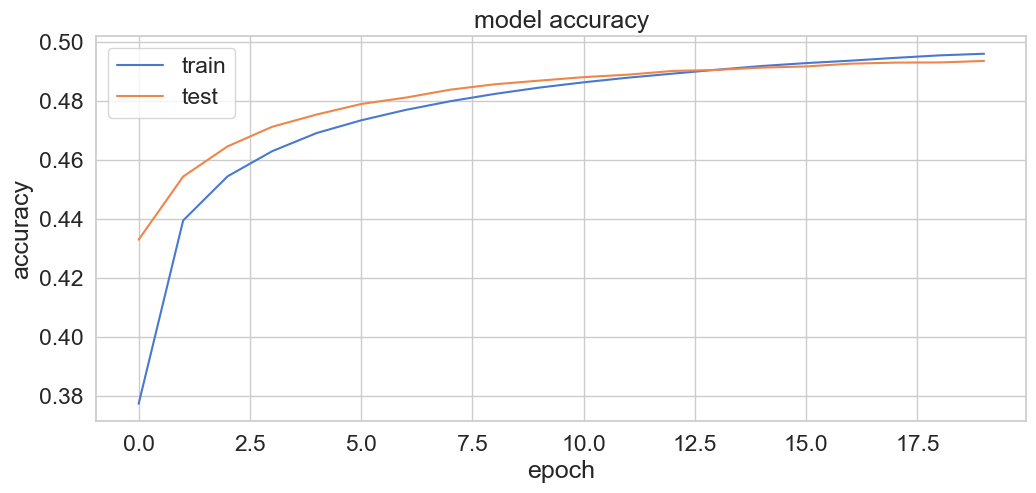

In [20]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

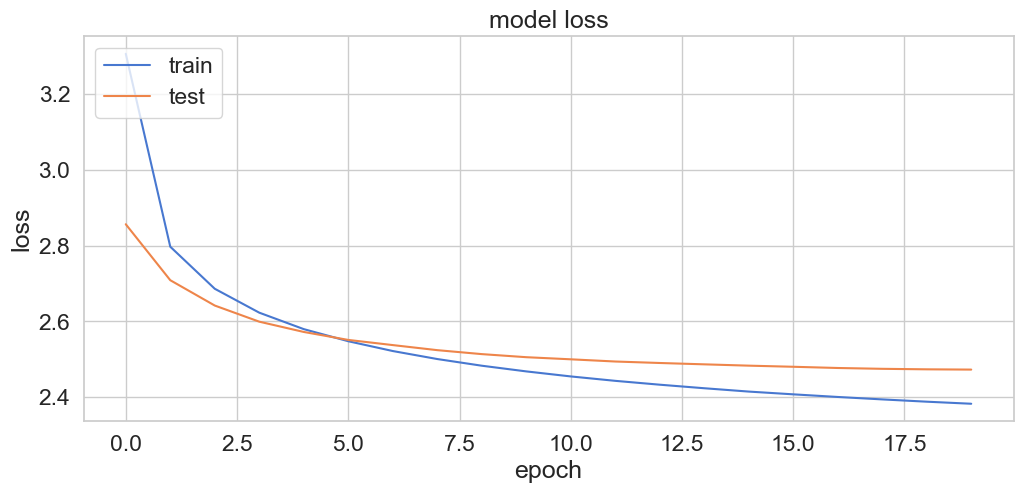

In [21]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## Phase 4: Inference and Temperature Sampling
In the generation phase, the model translates probability outputs into human-readable suggestions.
* **Temperature Scaling:** A temperature parameter is applied to the predictions to control "creativity".
    * A **low temperature** (e.g., $0.2$) makes the model confident and repetitive.
    * A **high temperature** (e.g., $1.0+$) allows the model to choose less likely but valid syllables.
* **Top-N Sampling:** The system returns the $N$ most likely completions (e.g., Top 3 or 5), mirroring the behavior of a modern smartphone keyboard.

In [22]:
def prepare_input(text):
    # Extract syllables from the tail of the input string
    sylls = extract_syllables(text)
    # Take the last SEQUENCE_LENGTH syllables
    last_sylls = sylls[-SEQUENCE_LENGTH:]

    # Convert syllables to indices
    # We use .get(syll, 0) to handle "Unknown" syllables safely
    indices = [syll_indices.get(syll, 0) for syll in last_sylls]

    # Reshape for the model: (batch_size=1, sequence_length)
    return np.array([indices], dtype='int32')

In [23]:
import heapq
def sample(preds, temperature=1.0, top_n=3):
    preds = np.asarray(preds).astype('float64')
    # Applying temperature (prevents the model from repeating the same word constantly)
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    # Return top N indices based on probability
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [24]:
def predict_completion(text, length=10, temperature=1.0):
    generated = text
    completion = ''

    for _ in range(length):
        x = prepare_input(generated)
        preds = model.predict(x, verbose=0)[0]

        # Get the most likely next syllable (top_n=1)
        next_index = sample(preds, temperature=temperature, top_n=1)[0]
        next_syll = indices_syll[next_index]

        # Append to results
        generated += next_syll
        completion += next_syll

    return completion

In [25]:
def predict_completions(text, n=3, temperature=1.0):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, temperature=temperature, top_n=n)
    return [indices_syll[idx] + predict_completion(text[1:] + indices_syll[idx]) for idx in next_indices]

### Test Text Generation

In [26]:
quots = [
    "မြန်မာ",
    "ကြက်တူရွေးစကား",
    "ကောင်းရောင်းကောင်းဝယ်လုပ်",
    "အလုပ်အကိုင်အခွင့်",
    "လုပ်ပိုင်ခွင့်",
    "ကိုရီး"
]

In [27]:
for q in quots:
    seq = ''.join(extract_syllables(q)[-SEQUENCE_LENGTH:])
    print(seq)
    print(predict_completions(seq, 5))
    print()

မြန်မာ
['           ', 'နိုင်ငံ အနှံ့အပြားတွင် တွေ့ရ', 'တို့ အားလုံးကို အသုံးပြုကြ', 'အား အာဏာရှင်စနစ် အ', 'လူမျိုးများ အများအပြား ရှိသည်']

ကြက်တူရွေးစကား
[' အမျိုးမျိုး ကွဲပြားခြားနားမှုများ', 'များ အသုံးပြုကြသည် အချို့သော', 'ကို အသုံးပြုကြသည် အချို့သော', 'လုံး          ', 'အားလုံးကို အသုံးပြုကြသည် ']

ကောင်းရောင်းကောင်းဝယ်လုပ်
['ခြင်း          ', 'ခဲ့သည်  ခုနှစ်တွင် အမေရိ', '           ', 'ရန် အတွက် အသုံးပြုကြသည် ', 'သူများ ဖြစ်ကြသည် အချို့သော ']

လုပ်အကိုင်အခွင့်
['အရေး အဖွဲ့အစည်းများ အတွက်', 'များ ရှိသည် အချို့သော အ', 'ကောင်း ဖြစ်သည် အခြား အာဏာ', ' အရေးများကို အသုံးပြုကြသည်', 'အာဏာ အများအပြား ရှိသည် ']

လုပ်ပိုင်ခွင့်
[' အာဏာ အပြည့်အထန် တိုက်', 'များ အတွက် အသုံးပြုကြသည် ', 'ကို အာဏာသိမ်းယူခဲ့သည်  ', 'ရှိသည်         ', 'အတွက် အသုံးပြုကြသည် အချို့']

ကိုရီး
['ယား နိုင်ငံ အနှံ့အပြားတွင် ', '           ', 'ရှ အာဏာပိုင်များက အုပ်', 'ရှား အမေရိကန်ပြည်ထောင်စု  ', 'နား အရှေ့တောင်အာရှတွင် တွေ့ရှိ']



In [28]:
predict_completion(quots[1], 20)

' အမျိုးမျိုး ကွဲပြားခြားနားမှုများ ရှိသည် အချို့သော အ'